# Variational Autoencoder

## 1. Settings

### 1) Import required libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image

### 2) Set hyperparameters

In [2]:
batch_size = 128
learning_rate = 1e-3
num_epochs = 10

## 2. Data

### 1) Download Data

In [3]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

In [4]:
mnist_train[0][0].size()    # (1, 28, 28)

torch.Size([1, 28, 28])

In [5]:
mnist_train[0][1]           # label

4

### 2) Set DataLoader

In [6]:
dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [7]:
len(dataloaders["train"])

391

## 3. Model & Optimizer

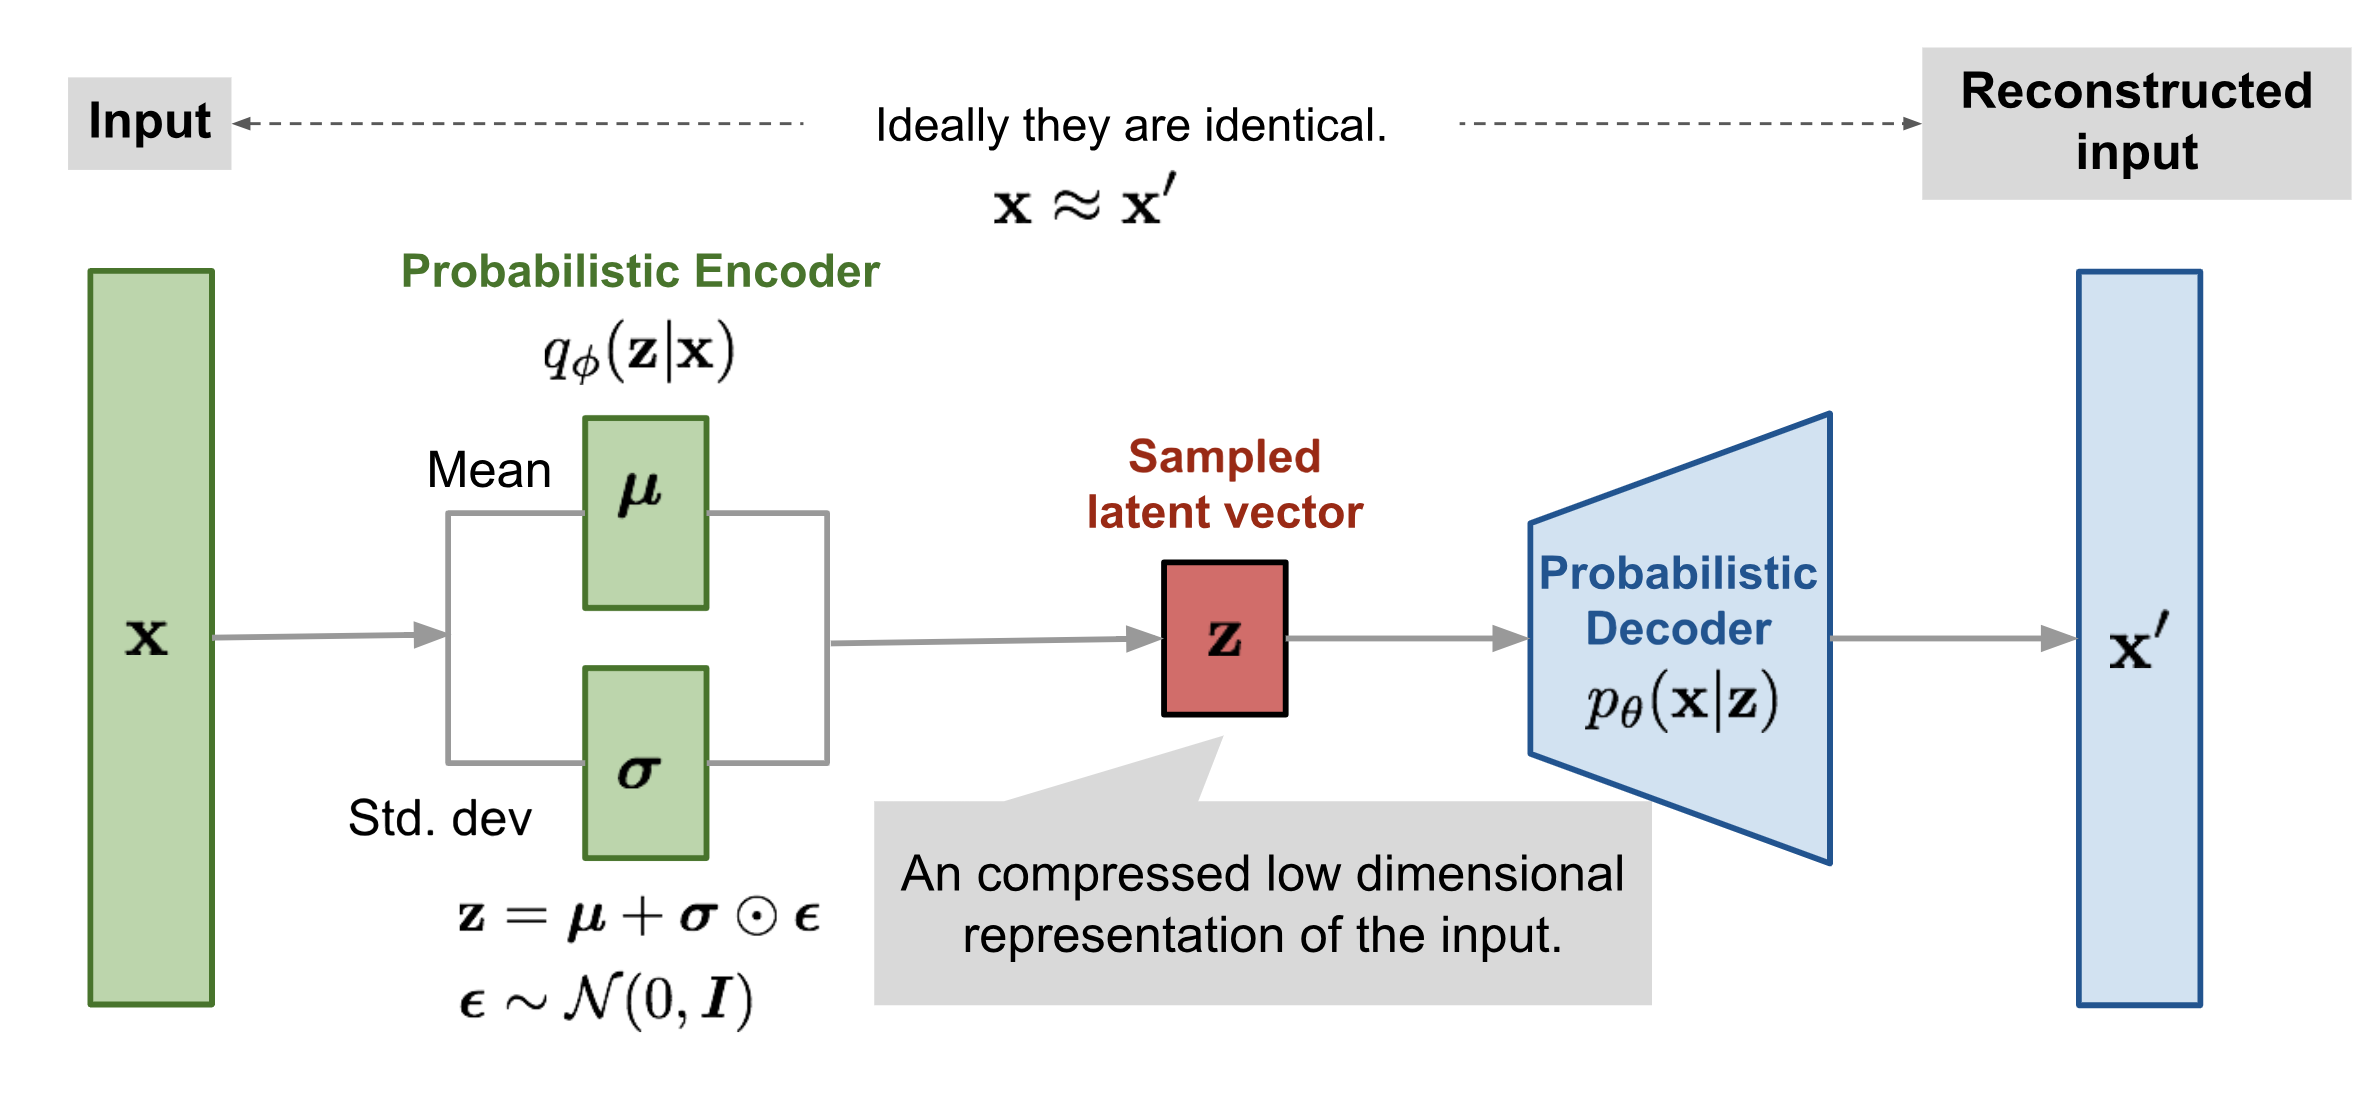

In [8]:
# https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html
Image("img/vae_gaussian.png")

### 1) Model

In [9]:
# build your own variational autoencoder
# encoder: 784(28*28) -> 512 -> 256
# sampling: 256 -> 10
# decoder: 10 -> 256 -> 512 -> 784(28*28)

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),    
            nn.ReLU(),                          # activation function
            nn.Linear(512, 256),
            nn.ReLU()                           # activation function
        )
        
        self.fc_mu = nn.Linear(256, 10)
        self.fc_var = nn.Linear(256, 10)
        
        self.decoder = nn.Sequential(
            nn.Linear(10, 256),
            nn.ReLU(),                          # activation function
            nn.Linear(256, 512),
            nn.ReLU(),                          # activation function
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )
                
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        recon = self.decoder(z)
        return recon
    
                
    def forward(self, x):                # x: (batch_size, 1, 28, 28)
        batch_size = x.size(0)
        mu, log_var = self.encode(x.view(batch_size, -1))
        z = self.reparameterize(mu, log_var)
        out = self.decode(z)
        return out, mu, log_var

### 2) Loss func & Optimizer

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
BCE = torch.nn.BCELoss(reduction='sum')

def loss_func(x, recon_x, mu, log_var):
    BCE_loss = BCE(recon_x, x.view(-1, 784))
    KLD_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE_loss + KLD_loss

In [12]:
model = VariationalAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 4. Train 

In [13]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)                                       # transfer inputs to GPU 

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs, mu, log_var = model(inputs)
                    loss = criterion(inputs, outputs, mu, log_var)  # calculate a loss


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()                             # perform back-propagation from the loss
                        optimizer.step()                             # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)

            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [14]:
best_model, train_loss_history, val_loss_history = train_model(model, dataloaders, loss_func, optimizer, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 179.2079
val Loss: 138.8560

Epoch 1/9
----------
train Loss: 129.3059
val Loss: 124.3950

Epoch 2/9
----------
train Loss: 119.1398
val Loss: 116.6241

Epoch 3/9
----------
train Loss: 113.8949
val Loss: 112.8185

Epoch 4/9
----------
train Loss: 110.9596
val Loss: 110.9515

Epoch 5/9
----------
train Loss: 109.1450
val Loss: 109.6580

Epoch 6/9
----------
train Loss: 107.7414
val Loss: 108.2632

Epoch 7/9
----------
train Loss: 106.7338
val Loss: 107.4635

Epoch 8/9
----------
train Loss: 105.8242
val Loss: 106.7388

Epoch 9/9
----------
train Loss: 105.1174
val Loss: 106.1633

Training complete in 1m 24s
Best val Loss: 106.163331


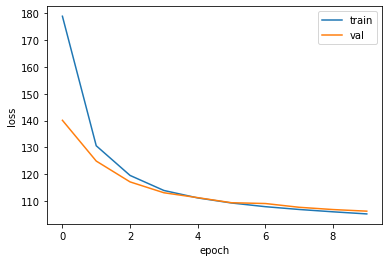

In [14]:
# Let's draw a learning curve like below.
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## 5. Check with Test Image (Can VAE reconstruct input images?)

In [15]:
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)

        outputs, mu, log_var = best_model(inputs)
        test_loss = loss_func(inputs, outputs, mu, log_var)
        
        running_loss += test_loss.item()

    test_loss = running_loss / len(dataloaders["test"].dataset)
    print(test_loss)        

105.22825858154297


torch.Size([16, 784])


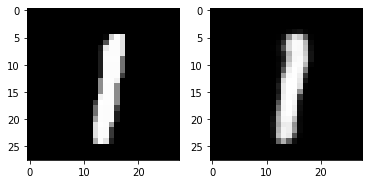

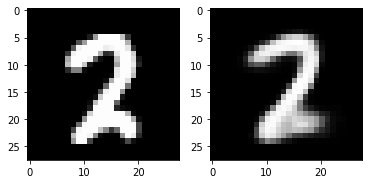

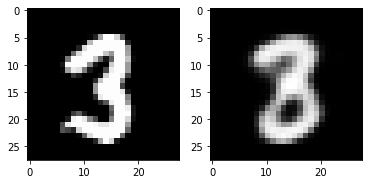

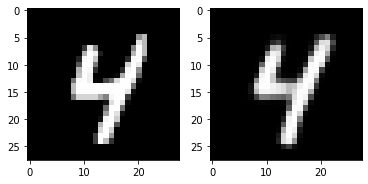

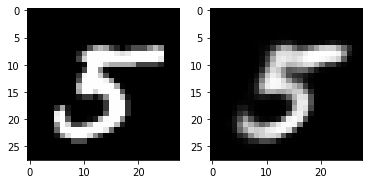

In [16]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy().reshape(28, 28),cmap='gray')
    plt.show()

## 6. Visualizing MNIST

In [17]:
np.random.seed(42)

from sklearn.manifold import TSNE

In [18]:
train_dataset_array = mnist_train.dataset.data.numpy() / 255
train_dataset_array = np.float32(train_dataset_array)
labels = mnist_train.dataset.targets.numpy()

In [19]:
subset_indices = []
subset_indices_per_class = []

for i in range(10):
    indices = np.where(labels == i)[0]
    subset_size = len(indices) // 6
    subset_indices += indices[:subset_size].tolist()
    subset_indices_per_class.append(indices[:subset_size].tolist())

train_dataset_array = train_dataset_array[subset_indices]
labels = labels[subset_indices]

In [20]:
train_dataset_array = torch.tensor(train_dataset_array)
inputs = train_dataset_array.to(device)
outputs, mu, log_var = best_model(inputs)

In [21]:
encoded = mu.cpu().detach().numpy()
tsne = TSNE()   
X_train_2D = tsne.fit_transform(encoded)
X_train_2D = (X_train_2D - X_train_2D.min()) / (X_train_2D.max() - X_train_2D.min())

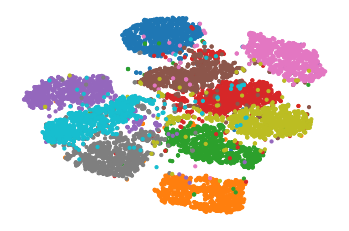

In [22]:
plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=labels, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

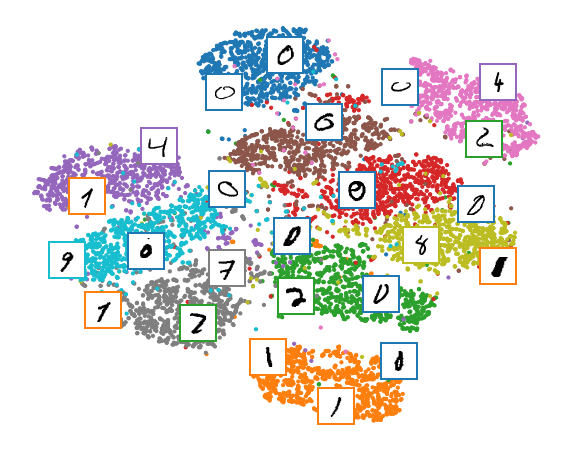

In [23]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=labels, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_train_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(torch.squeeze(inputs).cpu().numpy()[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## 7. Walk through latent space of MNIST

In [24]:
encoded.shape

(9996, 10)

In [25]:
mean_encoded = []
for i in range(10):
    mean_encoded.append(encoded[np.where(labels == i)[0]].mean(axis=0))


In [26]:
selected_class = [1, 7]
samples = []
with torch.no_grad():
    for idx, coef in enumerate(np.linspace(0, 1, 10)):
        interpolated = coef * mean_encoded[selected_class[0]] + (1.-coef) * mean_encoded[selected_class[1]]
        samples.append(interpolated)
    samples = np.stack(samples)
    z = torch.tensor(samples).to(device)
    generated = best_model.decoder(z).cuda()


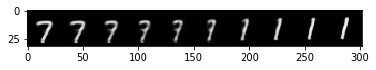

In [27]:
generated = generated.view(10, 1, 28, 28)
img = make_grid(generated, nrow=10)
npimg = img.cpu().numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [28]:
selected_class = [1, 8]
samples = []
with torch.no_grad():
    for idx, coef in enumerate(np.linspace(0, 1, 10)):
        interpolated = coef * mean_encoded[selected_class[0]] + (1.-coef) * mean_encoded[selected_class[1]]
        samples.append(interpolated)
    samples = np.stack(samples)
    z = torch.tensor(samples).to(device)
    generated = best_model.decoder(z).cuda()


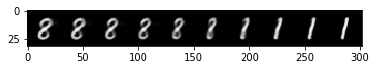

In [29]:
generated = generated.view(10, 1, 28, 28)
img = make_grid(generated, nrow=10)
npimg = img.cpu().numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')